In [1]:
%load_ext line_profiler

In [2]:
from collections import Counter
from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [3]:
# ns = [0,10,10,11,12,13,14,15,16,17]
# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# ns = [0]




# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 5
# # arrs = np.array([[20,0,0,0,0],
# #                  [19,19,0,0,0],
# #                  [18,18,18,0,0],
# #                  [17,17,17,17,0],
# #                  [16,16,16,16,16],])
# arrs = np.array([[20,0,0,0,0],
#                  [15,16,17,18,19],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                 ])
# arrs = arrs / 20
# display(arrs)
# display(arrs.sum().round(2))

# students = np.logspace(-2, 1, 13)
# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 10
# arrs = np.array([[1,0,0,0,0,0,0,0,0,0],
#                  [.95,.9,.85,.8,.75,.7,.65,.6,.55,.5],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  [0,0,0,0,0,0,0,0,0,0],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                  # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
#                 ])
# display(arrs)
# display(arrs.sum().round(2))
                 

students = np.logspace(-2, 2, 17)
ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
ms = 2
arrs = np.array([[1,0],[.95,.90]])
display(arrs)
display(arrs.mean().round(2))


ranked = False
top2 = True


slip = False
# students = np.linspace(0.05, 0.5, 10)

display(students.round(3))

array([[1.  , 0.  ],
       [0.95, 0.9 ]])

0.71

array([  0.01 ,   0.018,   0.032,   0.056,   0.1  ,   0.178,   0.316,   0.562,   1.   ,   1.778,   3.162,   5.623,  10.   ,  17.783,  31.623,  56.234, 100.   ])

In [4]:
def make_model(num_nodes=128, num_dense=4):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    
    inputs = tf.keras.layers.Input(shape=(ms*ms + ms + 1))
    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(num_dense):
        x = tf.keras.layers.Dense(num_nodes, activation='relu')(x)
    output1 = tf.keras.layers.Dense(ms, name='Y0')(x)
    output1 = tf.keras.layers.Softmax()(output1)
    model = tf.keras.models.Model(inputs=inputs, outputs=output1)
    
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return model

def softmax(x, b, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x/b) / np.exp(x/b).sum(axis=axis, keepdims=True)

def make_x():
    x = arrs
    
    # rand = np.random.random(arrs.shape)
    # rand = (rand - 0.5)
    # x = x + rand*0.0001
    
    x = rng.permuted(x, axis=-1)
    return x

def eval_model(model, n = 1, disable=True):
    rewards = []
    branch_rewards = []
    for _ in trange(n, disable=disable):
        x = make_x()
        x_tree = np.concatenate([np.eye(ms+1).astype(int), np.tile(x.flatten(), (ms+1,1))], axis=1)
        y_pred = model(x_tree).numpy()
        
        if top2:
            y_pred[0,2:] = 0
            y_pred[0] = y_pred[0] / y_pred[0].sum()
        
        branch_reward = (x_tree[0,ms+1:].reshape(ms,ms) * y_pred[1:]).sum(axis=1)
        rewards.append(y_pred[0])
        # reward = (y_pred[0] * branch_reward).numpy().sum()
        # rewards.append(reward)
        branch_rewards.append(branch_reward)
    return np.array(rewards), np.array(branch_rewards)

def make_data(b=1, n=1, disable=True):
    X, Y = [], []
    for _ in trange(n, disable=disable):
        
        if ranked:
            x = make_x()
            r1 = softmax(rankdata(x,axis=1), b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(rankdata(r1sum), b)
                    
        else:
            x = make_x()
            r1 = softmax(x, b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(r1sum, b)
        
        pos = [0] * (ms+1)
        pos[0] = 1
        x0 = pos + list(x.flatten())
        
        
        # slip_prob = np.log10(b)/-20 + 0.95
        slip_prob = b
        
        if slip == False:
            if top2:
                p = np.zeros_like(r0)
                p[:2] = r0[:2]
                p = p / p.sum()
            else:
                p = r0
            y0 = rng.choice(np.arange(ms), p=p)
        else:
            if top2:
                p = np.zeros_like(r0)
                p[0:2] = [1-slip_prob, slip_prob]
            else:
                p = np.zeros_like(r0)
                p[0] = 1-slip_prob
                p[1:] = slip_prob/(ms-1)
            y0 = rng.choice(np.arange(ms), p=p)
        # while y0 in [2,3,4]:
        #     y0 = rng.choice(np.arange(ms), p=r0)
            
        
        pos = [0] * (ms+1)
        pos[y0+1] = 1
        x1 = pos + list(x.flatten())
        
        if slip == False:
            y1 = rng.choice(np.arange(ms), p=r1[y0])
        else:
            p = np.zeros(ms) + (slip_prob)/(ms-1)
            p[r1.argmax()] = 1 - slip_prob
            y1 = rng.choice(np.arange(ms), p=p)

        X.append(x0)
        Y.append(y0)
        X.append(x1)
        Y.append(y1)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [5]:
%%time
for b in students:
    r0s = []
    r1s = []
    for _ in trange(10000, disable=True):
        x = make_x()
        
        if ranked:
            r1 = (softmax(rankdata(x,axis=1), b) * x).sum(axis=1)
            r0 = (softmax(rankdata(r1), b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
            
        else:
            r1 = (softmax(x, b) * x).sum(axis=1)
            r0 = (softmax(r1, b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
    
        
    r1s = np.array(r1s)
    r0s = np.array(r0s)
    print(f"{b:.3f}, {r0s.mean():.3f}, {r1s.mean(axis=0).round(3)}, {softmax(r1s.mean(axis=0), b).round(3)}")

0.010, 1.000, [1.   0.95], [0.994 0.006]
0.018, 0.997, [1.    0.947], [0.951 0.049]
0.032, 0.992, [1.    0.941], [0.864 0.136]
0.056, 0.984, [1.    0.935], [0.759 0.241]
0.100, 0.977, [1.    0.931], [0.666 0.334]
0.178, 0.969, [0.996 0.928], [0.594 0.406]
0.316, 0.944, [0.959 0.927], [0.526 0.474]
0.562, 0.893, [0.855 0.926], [0.469 0.531]
1.000, 0.838, [0.731 0.926], [0.452 0.548]
1.778, 0.793, [0.637 0.925], [0.46 0.54]
3.162, 0.761, [0.578 0.925], [0.473 0.527]
5.623, 0.741, [0.544 0.925], [0.483 0.517]
10.000, 0.729, [0.525 0.925], [0.49 0.51]
17.783, 0.722, [0.514 0.925], [0.494 0.506]
31.623, 0.718, [0.508 0.925], [0.497 0.503]
56.234, 0.716, [0.504 0.925], [0.498 0.502]
100.000, 0.714, [0.502 0.925], [0.499 0.501]
CPU times: user 7.03 s, sys: 0 ns, total: 7.03 s
Wall time: 7.09 s


In [6]:
def train_model(i, student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/starting_{student:.3f}_{i}.keras')
    model.save_weights(f'models/starting_{student:.3f}_{i}.weights.h5')
    return reward

In [ ]:
%%time

iters = list(range(10))
iter_students = [1000 for i in iters]
rewards = process_map(train_model, iters, iter_students, disable=False, max_workers=20)

# rewards = process_map(train_model, students, disable=True, max_workers=17)

In [ ]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

# Graphs

In [ ]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.get_logger().setLevel('ERROR')
model2 = tf.keras.models.load_model(f"models/starting_{0.100:.3f}.keras")
%timeit r0, r1 = eval_model(model2, 1)

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_batch_end(self, batch, logs=None):
        
        r0, r1 = eval_model(self.model, 10)
        r = (r0*r1).sum(axis=1).mean()
        try:
            self.model.rewards.append(r)
            self.model.accs.append(logs['accuracy'])
        except:
            self.model.rewards = [r]
            self.model.accs = [logs['accuracy']]

In [ ]:
models = {}

In [ ]:
%%time

with open('tree.log', 'a') as f:
    for student in students:
        
        print(f'student {student:.3f}', file=f, flush=True)

        models[student] = {}

        for teacher in students[::2][3:10]:

            print(f'teacher {teacher:.3f}', file=f, flush=True)
            models[student][teacher] = []
            for i in range(5):
                print(f'model {i}', file=f, flush=True)
                # model = make_model()
                model = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")

                opt = tf.keras.optimizers.Adam()
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

                X, Y = currs[f'{teacher:.3f}']
                model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()], verbose=False)
                # model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()])

                models[student][teacher].append(model)


        #         break
        #     break
        # break

In [ ]:
for student, s_models in models.items():
    # print(student, list(s_models))
    df = {}
    for teacher, model in s_models.items():
        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        rewards = np.array([m.rewards for m in model]).mean(axis=0)
        rewards = np.convolve(rewards, kernel, mode='valid')
        df[f"{teacher:.3f}"] = rewards
    df = pd.DataFrame(df)
    
    print(f'Student {student:.3f}')
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.lineplot(df[[c for c in df.columns if float(c) >= student]])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.show()
    print()

In [ ]:
df[[c for c in df.columns if float(c) >= 1]]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
1+1

In [ ]:
ax = sns.lineplot(df[df.columns[4:9]])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
students[::2][4:9]

In [ ]:
2**17 // 32

# Eval Training

In [7]:
%%time
ntotal = (2**np.array(ns[1:13])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 109 ms, sys: 207 ms, total: 316 ms
Wall time: 10.4 s


In [310]:
def eval_training(modeli, student, teachers, verbose=False):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
        
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()

        def on_batch_begin(self, batch, logs=None):
            
            # batches = list(2**np.arange(5,18) // 32 - 1)            
            # if batch in batches:
                
            if batch % 1 == 0:
                r0, r1 = eval_model(self.model, 10)
                r = (r0*r1).sum(axis=1).mean()
                try:
                    self.model.rewards[batch] = r
                    # self.model.accs.append(logs['accuracy'])
                except:
                    self.model.rewards = {batch: r}
                    # self.model.accs = [logs['accuracy']]

    
    if student == -1:
        model2 = make_model()
    else:
        # model2 = make_model()
        # model2.load_weights(f"models/starting_{student:.3f}_{i%10}.weights.h5")
        model2 = tf.keras.models.load_model(f"models/starting_{student:.3f}_{modeli%10}.keras")
        
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    
    bs = 32
    
    if teachers == ('smooth',):
        _X0, _Y0 = currs[f"{0.010:.3f}"]
        _X1, _Y1 = currs[f"{0.316:.3f}"]
        
        
        perm = np.random.permutation(len(_X0))[:num_batches*bs]
        _X0, _Y0 = _X0[perm], _Y0[perm]
        
        perm = np.random.permutation(len(_X1))[:num_batches*bs]
        _X1, _Y1 = _X1[perm], _Y1[perm]
        
        where = np.concatenate([np.zeros(0*bs) , np.linspace(0.5, 1, 50*bs), np.ones(150*bs)])
        where = where > np.random.random(num_batches*bs)
        
        
        X = np.where(where.reshape((-1, 1)), _X0, _X1)
        Y = np.where(where, _Y0, _Y1)
        
    elif teachers[0] == 'bins':
        nbins = teachers[1]
        binsize = 4//nbins
        X, Y = [], []
        
        for i, teacher in enumerate(students[::4][:4]):
            if i%binsize == 0:
                X.append([])
                Y.append([])
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:50*bs]
            X[-1].append(_X[perm])
            Y[-1].append(_Y[perm])
            
        
        X = [np.concatenate(_X) for _X in X]
        Y = [np.concatenate(_Y) for _Y in Y]
        
        # print(teachers, nbins, binsize)
        # print([_X.shape for _X in X])
        # print([_Y.shape for _Y in Y])
        
        perm = np.random.permutation(len(X[0]))
        
        X = [_X[perm] for _X in X][::-1]
        Y = [_Y[perm] for _Y in Y][::-1]
        
        # print([_X.shape for _X in X])
        # print([_Y.shape for _Y in Y])
        
        X, Y = np.concatenate(X), np.concatenate(Y)
        
        # print(X.shape, Y.shape)
        
            
            
        
        
    else:
        X, Y = [], []
        for teacher, n in teachers:
            
            if isinstance(teacher, tuple):
                X.append([])
                Y.append([])
                for teacher_part in teacher:
                    _X, _Y = currs[f"{teacher_part:.3f}"]
                    perm = np.random.permutation(len(_X))[:bs * n//len(teacher)]
                    X[-1].append(_X[perm])
                    Y[-1].append(_Y[perm])
                X[-1] = np.concatenate(X[-1])
                Y[-1] = np.concatenate(Y[-1])
                perm = np.random.permutation(len(X[-1]))
                X[-1] = X[-1][perm]
                Y[-1] = Y[-1][perm]
            
            else:
                _X, _Y = currs[f"{teacher:.3f}"]
                perm = np.random.permutation(len(_X))[:n*bs]
                X.append(_X[perm])
                Y.append(_Y[perm])

        lx = len(X[0])
                
        pct = 0.2
        
        assert (pct*lx) % 1 == 0
        pct = int(pct * lx)

        mixX = np.concatenate([_X[lx-pct:] for _X in X])
        mixY = np.concatenate([_Y[lx-pct:] for _Y in Y])
        
        # print(pct, len(X[0]), mixX.shape, mixY.shape)
        
        for i, (_X, _Y) in enumerate(zip(X, Y)):
            _X[lx-pct:] = mixX[i::len(X)]
            _Y[lx-pct:] = mixY[i::len(Y)]
            perm = np.random.permutation(lx)
            _X[:] = _X[perm]
            _Y[:] = _Y[perm]
        
        X, Y = np.concatenate(X), np.concatenate(Y)
        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()])    
    return (student, teachers, model2.rewards)


In [311]:
def exp(student, verbose=True, n=20, nb=100):
    # teachers = np.arange(student, 0.40001, 0.02)
    
    # teachers = students[:6]
    
    # teachers = [
    #             # ((0.010, num_batches),),
    #             # ((0.015, num_batches),),
    #             # ((0.022, num_batches),),
    #             # ((0.032, num_batches),),
    #             # ((0.046, num_batches),),
    #             # ((0.068, num_batches),),
    #             ((0.100, num_batches),),
    #             ((0.147, num_batches),),
    #             ((0.215, num_batches),),
    #             ((0.316, num_batches),),
    #             ((0.464, num_batches),),
    #             # ((0.681, num_batches),),
    #             # ((1.000, num_batches),), 
    #             # ((1.000, 300),),
    #             # ((0.158, 25),(0.1, 175),),
    #             # ((0.158, 50),(0.1, 150),),
    #             # ((0.158, 75),(0.1, 125),),
    #             # ((0.158, 100),(0.1, 100),),
    #             # ((0.158, 125),(0.1, 75),),
    #             # ((1, 128),),
    #             # ("smooth",)
    #            ]
    
    teachers = [
        # # ((0.018, num_batches),),
        # ((0.032, num_batches),),
        # # ((0.056, num_batches),),
        # ((0.100, num_batches),),
        # ((0.178, num_batches),),
        # ((0.316, num_batches),),
        # ((0.562, num_batches),),
        # ((1.000, num_batches),),
        # ((1.778, num_batches),),
        # ((3.162, num_batches),),
        # # ((5.623, num_batches),),
        # ((10.000, num_batches),),
        # # ((0.316, 50),(0.010, 150),),
        # # ("smooth",),
        
        
        
        # [(0.010, nb)],
        # [((0.010,0.032,0.100,0.316), nb)],
        # [((0.316,0.100), nb//2),
        #  ((0.032,0.010), nb//2)],
        # [(0.316, nb//4),
        #  (0.100, nb//4),
        #  (0.032, nb//4),
        #  (0.010, nb//4)],
        
        [(0.010, nb//4)],
        [((0.010,0.100,1.000,10.00), nb)],
        [((10.00,1.000), nb//2),
         ((0.100,0.010), nb//2)],
        [(10.00, nb//4),
         (1.000, nb//4),
         (0.100, nb//4),
         (0.010, nb//4)],        
        
    ]
    
    # teachers = [
    #         ((0.05, num_batches),),
    #         ((0.10, num_batches),),
    #         ((0.15, num_batches),),
    #         ((0.20, num_batches),),
    #         ((0.25, num_batches),),
    #         ((0.30, num_batches),),
    #         ((0.35, num_batches),),
    #         ((0.40, num_batches),),
    #         ((0.45, num_batches),),
    #         ((0.50, num_batches),),
    #        ]

    
        
    t_ = list(teachers) * n
    s_ = [student for _ in t_]
    iters = [i for i,_ in enumerate(t_)]
    
    res = process_map(eval_training, iters, s_, t_, max_workers=21, chunksize=1)
    
    return res

In [312]:
%%time
def analyze(student, n, num_batches):
    res = exp(student, n=n, nb=num_batches)
    res2 = {}
    for s, t, d in res:
        s = f"{s:.3f}"
        t = str(t)

        if (s,t) not in res2:
            res2[s,t] = [list(d.values())]
        else:
            res2[s,t].append(list(d.values()))

    res2 = {k:list(np.array(v)) for k,v in res2.items()}
    df = pd.DataFrame(res2.values())
    df.index = res2.keys()
    df.index.names = ('Student', 'Teacher')
    df = df.melt(ignore_index=False, var_name='Exp', value_name='Perf')
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        perf = df.Perf.tolist()
        m = max([len(i) for i in perf])
        perf = np.array([np.pad(i, (0,m-len(i)), constant_values=np.nan) for i in perf])
        df[np.arange(m)] = perf
    df = df.drop(columns='Perf')
    df = df.reset_index().set_index(['Student','Teacher','Exp'])
    df = df.melt(ignore_index=False, var_name='Batch', value_name='Perf').reset_index()
    df['Teacher'] = df.Teacher.astype(str)
    df2 = df.groupby(['Teacher','Batch']).Perf.mean().reset_index()
    df2['Perf2'] = df2.groupby('Teacher')['Perf'].transform(lambda x: x.rolling(10,1).mean())
    df2.Perf2 -= df2[df2.Batch==0].Perf2.mean()
    df2.Perf -= df2[df2.Batch==0].Perf.mean()
    return df2

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 52.5 µs


In [316]:
num_batches = 200

# sub = [
        # ((0.010, 80),),
#         # ((0.018, num_batches),),
#         # ((0.032, num_batches),),
#         # ((0.056, num_batches),),
#         ((0.100, num_batches),),
#         # ((0.178, num_batches),),
#         # ((0.316, num_batches),),
#         # ((0.562, num_batches),),
#         ((1.000, num_batches),),
#         # ((1.778, num_batches),),
#         # ((3.162, num_batches),),
#         # ((5.623, num_batches),),
#         ((10.000, num_batches),),
#         # ((0.316, 25),(0.010, num_batches-25),),
#         # ("smooth",),
#     ]

In [317]:
df2 = analyze(student=-1, n=200, num_batches=num_batches)

  0%|          | 0/800 [00:00<?, ?it/s]

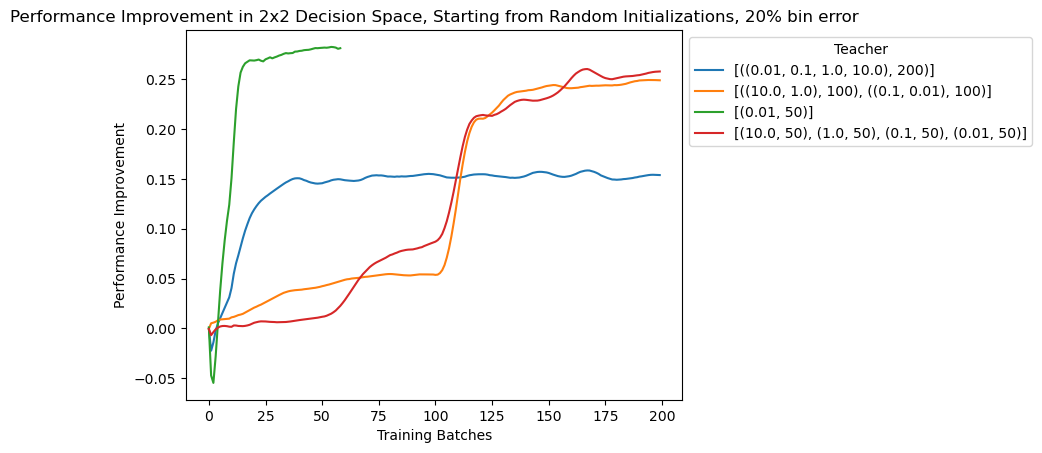

In [318]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[(df2.Batch<=1000)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df2[df2.Teacher.isin(sub)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Random Initializations, 20% bin error',
        xlabel='Training Batches',
        ylabel='Performance Improvement'
    )

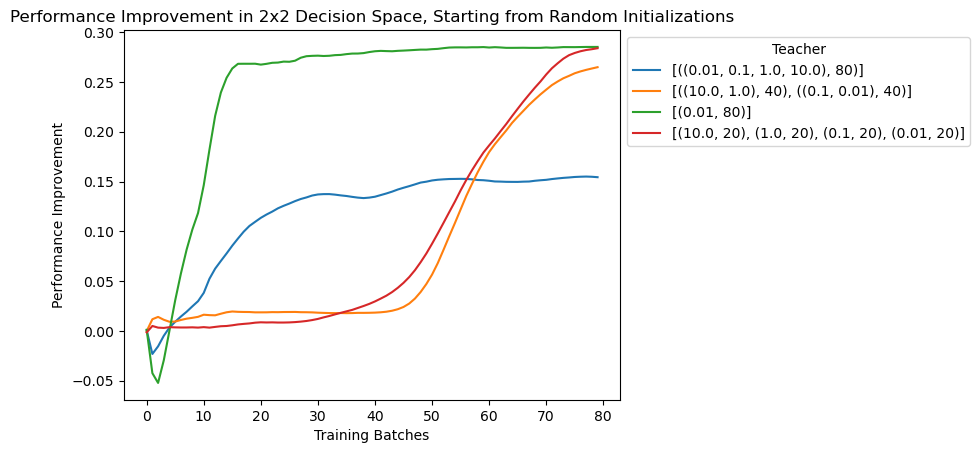

In [217]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[(df2.Batch<=1000)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df2[df2.Teacher.isin(sub)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Random Initializations',
        xlabel='Training Batches',
        ylabel='Performance Improvement'
    )

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[(df2.Batch<=1000)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df2[df2.Teacher.isin(sub)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from 1000 Model',
        xlabel='Training Batches',
        ylabel='Performance Improvement'
    )

In [ ]:
df2 = analyze(student=-1, n=50, num_batches=num_batches)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[(df2.Batch<=1000) & df2.Teacher.isin(sub)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df2[df2.Teacher.isin(sub)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Random Initializations',
        xlabel='Training Batches',
        ylabel='Performance Improvement'
    )

In [ ]:
list(currs)